# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [fashion MNIST.](https://www.cs.toronto.edu/~kriz/cifar.html) 

In [1]:
import tensorflow as tf
tf.__version__ 

'2.6.0'

In [2]:
from tensorflow.keras import Sequential
keras, L = tf.keras, tf.keras.layers

import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Отнормировали данные к отрезку [0;1]
X_train = X_train/ 255.
X_test = X_test/ 255.

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
print("Train samples:", X_train.shape, y_train.shape)
print("Test samples:", X_test.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


Нарисуем несколько рандомных картинок из тренировочной выборки. 

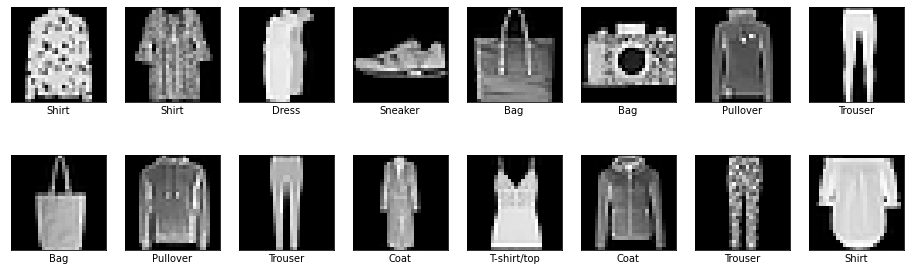

In [5]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://keras.io/layers/convolutional/#conv2d) - Конволюция:
    - **filters**: число выходных каналов; 
    - **kernel_size**: размер окна для свёртки;
    - **padding**: padding="same" добавляет нулевую каёмку по краям картинки, чтбы после свёртки размеры картинки не изменялись; padding='valid' ничего не добавляет;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: размер входа
* [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - макспулинг
* [Flatten](https://keras.io/layers/core/#flatten) - разворачивает картинку в вектор 
* [Dense](https://keras.io/layers/core/#dense) - полносвязный слой (fully-connected layer)
* [Activation](https://keras.io/layers/core/#activation) - функция активации
* [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - leaky relu активация
* [Dropout](https://keras.io/layers/core/#dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

## 2.1 Полносвязная сетка 

Соберём полносвязную сетку с нашей предыдущей пары/ 

In [6]:
tf.random.set_seed(42)

model_1 = Sequential( )

model_1.add(L.Flatten(input_shape=(28, 28)))

model_1.add(L.Dense(64))
model_1.add(L.BatchNormalization()) 
model_1.add(L.Activation('relu'))

model_1.add(L.Dense(32))
model_1.add(L.BatchNormalization()) 
model_1.add(L.Activation('relu'))

model_1.add(L.Dense(16))
model_1.add(L.BatchNormalization()) 
model_1.add(L.Activation('relu'))

model_1.add(L.Dense(10, activation='softmax'))

model_1.compile("adam", "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

hist = model_1.fit(X_train, y_train, validation_split= 0.2,
                        batch_size=500, epochs=10, verbose=1)

Epoch 1/10
96/96 [==============================] - 2s 6ms/step - loss: 1.2307 - sparse_categorical_accuracy: 0.7028 - val_loss: 1.2448 - val_sparse_categorical_accuracy: 0.8058
Epoch 2/10
96/96 [==============================] - 0s 4ms/step - loss: 0.6524 - sparse_categorical_accuracy: 0.8449 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.8407
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 0.4661 - sparse_categorical_accuracy: 0.8669 - val_loss: 0.5075 - val_sparse_categorical_accuracy: 0.8441
Epoch 4/10
96/96 [==============================] - 0s 4ms/step - loss: 0.3885 - sparse_categorical_accuracy: 0.8787 - val_loss: 0.4682 - val_sparse_categorical_accuracy: 0.8401
Epoch 5/10
96/96 [==============================] - 0s 4ms/step - loss: 0.3470 - sparse_categorical_accuracy: 0.8857 - val_loss: 0.4365 - val_sparse_categorical_accuracy: 0.8541
Epoch 6/10
96/96 [==============================] - 0s 4ms/step - loss: 0.3190 - sparse_categorical_accuracy: 

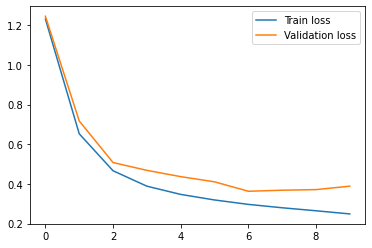

In [7]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [8]:
print("\nLoss, Accuracy = ", model_1.evaluate(X_test, y_test, verbose=0))


Loss, Accuracy =  [0.3987915813922882, 0.8615999817848206]


Можно посмотреть, где именно сетка ошибается. 

In [9]:
y_pred = np.argmax(model_1.predict(X_test), axis=1)
errors =  y_pred != y_test

# срежем только наблюдения, где была ошибка вместе с метками
X_err = X_test[errors]
y_err = y_test[errors]
y_pred = y_pred[errors]

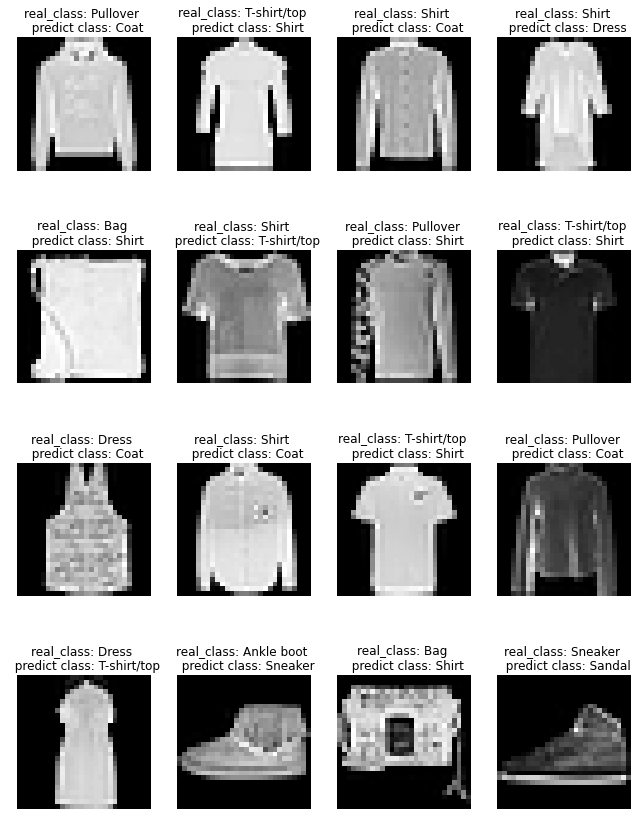

In [10]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

## 2.2 Свёрточная сетка 

Во-первых, нужно в явном виде указать, что у нас в изображениях один канал. Иначе питон будет ругаться.

In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
X_train[:,:,:,np.newaxis].shape

(60000, 28, 28, 1)

In [13]:
X_train = X_train[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$, same padding и $32$ каналами
* ReLU
* Макспулинг размера $2 \times 2$
* Свёртка с ядром $5 \times 5$ и $16$ каналами  и valid padding
* ReLU
* Макспулинг размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $60$ нейронами

In [51]:
tf.random.set_seed(42)

model_2 = keras.Sequential()

model_2.add(L.Conv2D(kernel_size=(5, 5), filters=32, padding='same', input_shape=(28,28,1)))
model_2.add(L.ReLU())
model_2.add(L.MaxPool2D(pool_size=(2,2)))

model_2.add(L.Conv2D(kernel_size=(5, 5), filters=16, padding='same')) 
model_2.add(L.ReLU())
model_2.add(L.MaxPool2D(pool_size=(2,2), strides=(2, 2)))

model_2.add(L.Flatten())

model_2.add(L.Dense(units=120, activation='relu'))

model_2.add(L.Dense(units=60, activation='relu'))

model_2.add(L.Dense(units=10, activation = 'softmax'))

model_2.compile("adam", "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])


In [52]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 16)        12816     
_________________________________________________________________
re_lu_5 (ReLU)               (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)              

In [53]:
hist = model_2.fit(X_train, y_train, validation_split= 0.2,
                        batch_size=500, epochs=10, verbose=1)

Epoch 1/10
96/96 [==============================] - 2s 15ms/step - loss: 0.8615 - sparse_categorical_accuracy: 0.6964 - val_loss: 0.5558 - val_sparse_categorical_accuracy: 0.7916
Epoch 2/10
96/96 [==============================] - 1s 12ms/step - loss: 0.4899 - sparse_categorical_accuracy: 0.8232 - val_loss: 0.4606 - val_sparse_categorical_accuracy: 0.8332
Epoch 3/10
96/96 [==============================] - 1s 12ms/step - loss: 0.4161 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.4072 - val_sparse_categorical_accuracy: 0.8528
Epoch 4/10
96/96 [==============================] - 1s 12ms/step - loss: 0.3793 - sparse_categorical_accuracy: 0.8651 - val_loss: 0.3791 - val_sparse_categorical_accuracy: 0.8649
Epoch 5/10
96/96 [==============================] - 1s 12ms/step - loss: 0.3463 - sparse_categorical_accuracy: 0.8760 - val_loss: 0.3543 - val_sparse_categorical_accuracy: 0.8760
Epoch 6/10
96/96 [==============================] - 1s 12ms/step - loss: 0.3274 - sparse_categorical_accu

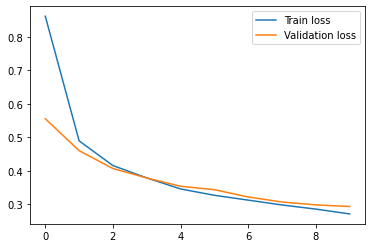

In [54]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [55]:
print("\nLoss, Accuracy = ", model_2.evaluate(X_test, y_test, verbose=0))


Loss, Accuracy =  [0.31355521082878113, 0.8858000040054321]


Как видите, точность выросла

Посмотри на ошибки сети

In [56]:
X_test.shape

(10000, 28, 28, 1)

In [57]:
np.squeeze(X_test, axis=3).shape

(10000, 28, 28)

In [58]:
y_pred = np.argmax(model_2.predict(X_test), 1)
errors =  y_pred != y_test

X_err = np.squeeze(X_test[errors], axis=3)
y_err = y_test[errors]
y_pred = y_pred[errors]

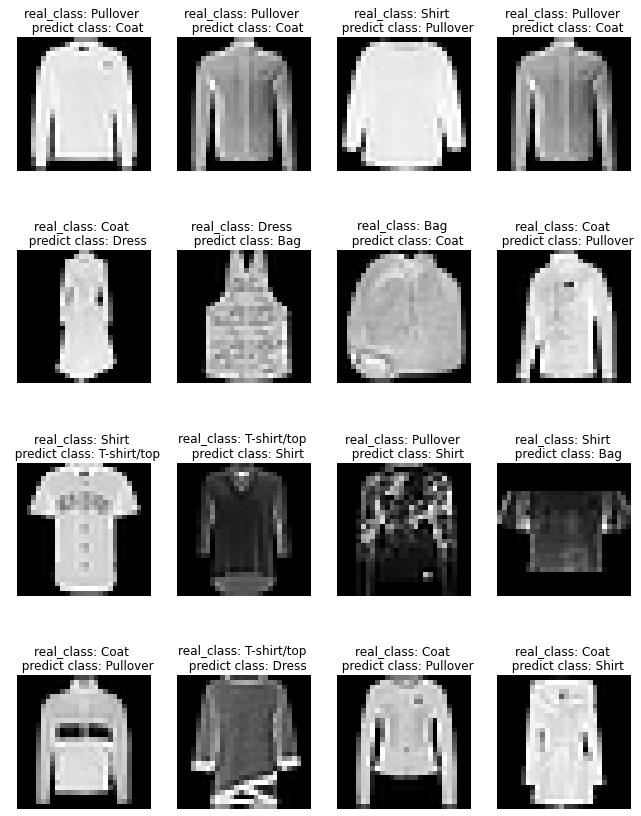

In [59]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

## 3.  Data augmentation

Попробуем обучить ту же модель, но искуственно расширяя набор данных за счёт [случайных искажений.](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* `rotation_range`  значение в градусах (0-180), диапазон, в пределах которого произвольно вращаются изображения;
* `width_shift` и `height_shift` это диапазоны (в долях от общей ширины или высоты), в пределах которых можно произвольно сдвигать изображения по вертикали или горизонтали;
* `zoom_range` для случайного масштабирования внутри фотографий
* `horizontal_flip` для переворачивания половины изображения по горизонтали
* `fill_mode` стратегия для заполнения вновь появившихся пикселей

In [66]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
        )

In [67]:
datagen.fit(X_train) # обучили генератор 

Если обучить нейронку с использованием этих настроек, она никогда не увидит одно и то же изображение дважды. Однако входные данные по-прежнему будут довольно сильно связаны между собой. Мы пытаемся исказить уже существующие объекты так, чтобы они всё ещё оставались собой, но нейронка не выучивала детали, присущие конкретным наблюдениям, то есть __не переобучалась.__ 

In [68]:
# Настраиваем поток данных 
# Возьмём одну картинку 10 раз и подадим её на вход

it = datagen.flow(np.array(10*[X_train[200]]), np.array(10*[y_train[200]]), batch_size=10) # итератор 

images, categories = it.next()
print("Number of images returned by iterator:", len(images))

Number of images returned by iterator: 10


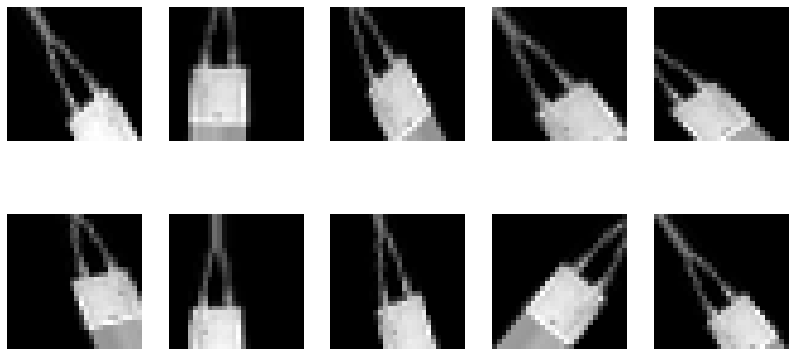

In [69]:
cols = 5
rows = 2
k = 0

fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        im = np.squeeze(images[k], axis=2)
        k += 1
        
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(im, cmap='gray')

plt.show()

Настроим поток для всей выборки. Каждая картинка будет искажаться один раз и подаваться на вход в нейронку. 

In [70]:
# Кусочек откусываем для валидации
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)

it = datagen.flow(X_tr, y_tr, batch_size=256)

Скопируем сетку из предыдущего пункта. 

In [77]:
model_3 = keras.Sequential()

model_3.add(L.Conv2D(kernel_size=(5, 5), filters=32, padding='same', input_shape=(28,28,1)))
model_3.add(L.ReLU())
model_3.add(L.MaxPool2D(pool_size=(2,2)))

model_3.add(L.Conv2D(kernel_size=(5, 5), filters=16, padding='same')) 
model_3.add(L.ReLU())
model_3.add(L.MaxPool2D(pool_size=(2,2), strides=(2, 2)))

model_3.add(L.Flatten())

model_3.add(L.Dense(units=120, activation='relu'))

model_3.add(L.Dense(units=60, activation='relu'))

model_3.add(L.Dense(units=10, activation = 'softmax'))

model_3.compile("adam", "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

Обучим сетку. Для этого будем использовать метод `fit_generator`. Так как данные генерируются до бесконечности, модель должна знать сколько образцов надо извлечь перед тем как закончить эпоху. За это отвечает параметр `steps_per_epoch`. После извлечения из генератора `steps_per_epoch` батчей сетка переходит к новой эпохе.

In [78]:
hist = model_3.fit_generator(
    it,
    steps_per_epoch=10,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 2s 162ms/step - loss: 2.2166 - sparse_categorical_accuracy: 0.1840 - val_loss: 1.8676 - val_sparse_categorical_accuracy: 0.3333
Epoch 2/10
10/10 [==============================] - 1s 133ms/step - loss: 1.8517 - sparse_categorical_accuracy: 0.3117 - val_loss: 1.2942 - val_sparse_categorical_accuracy: 0.4940
Epoch 3/10
10/10 [==============================] - 1s 129ms/step - loss: 1.6667 - sparse_categorical_accuracy: 0.3828 - val_loss: 1.1673 - val_sparse_categorical_accuracy: 0.5783
Epoch 4/10
10/10 [==============================] - 1s 126ms/step - loss: 1.4934 - sparse_categorical_accuracy: 0.4484 - val_loss: 1.0734 - val_sparse_categorical_accuracy: 0.6178
Epoch 5/10
10/10 [==============================] - 1s 123ms/step - loss: 1.4099 - sparse_categorical_accuracy: 0.4816 - val_loss: 0.9644 - val_sparse_categorical_accuracy: 0.6371
Epoch 6/10
10/10 [==============================] - 1s 125ms/step - loss: 1.3562 - sparse_categorica

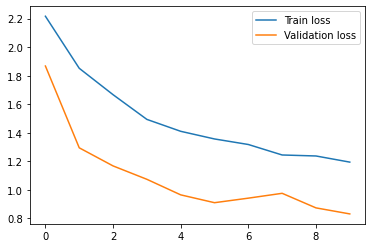

In [79]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [80]:
print("Loss, Accuracy = ", model_3.evaluate(X_test, y_test, verbose=0))

Loss, Accuracy =  [0.8421186804771423, 0.6880000233650208]


Такую сетку надо учить подольше. В этой тетрадке она реализована просто как пример аугментации данных. Побиться за реальное улучшение качества вам предстоит в следующих домишних заданиях 

## Homework
1. Попробовать разные архитектуры сети. Изменить кол-во слоев, параметры слоев, batchsize, кол-во эпох обучения, оптимизаторы
2. Построить сетку с Accuracy на test-выборке >90%
